In [11]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
from algbench import read_as_pandas, Benchmark
import re
from collections import defaultdict
import matplotlib.ticker as mtick
import os

os.makedirs("out/", exist_ok=True)

font = {'family': 'serif', 'size': 11}
matplotlib.rc('font', **font)

plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = "Times New Roman"
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['figure.figsize'] = [4.5, 3.5]

sns.set_theme()

matplotlib.rcParams['axes.prop_cycle'] = matplotlib.cycler(color=[
    "#6E2C00",
    "#27AE60",
    "#9B59B6",
    "#CB4335",
    "#089099",
    "#7C1D6F"
]) 
result_paths = ['results/classical_benchmark/qtg/hard']  #'results/classical_benchmark/qtg/hard']

In [4]:
def _row_correction(row):
    # this function makes sure that the values in the results are uniform even though they are not
    # produced by the same solver

    def set_infeasible():
        row['result']['objective_value'] = np.inf
        row['result']['item_assignments'] = None
        row['result']['feasible'] = False
        row['result']['optimal'] = False

    row['result']['feasible'] = True
    row['result']['objective_value'] = round(row['result']['objective_value'])
    if row['result']['objective_value'] < 0:
        set_infeasible()

    if row['result']['item_assignments']:
        items = row['parameters']['args']['instance']['items']
        obj_val = sum(items[i]["profit"] for i, x in enumerate(row['result']['item_assignments']) if x == True)

        if round(row['result']['objective_value']) != obj_val:
            # There was an numerical error during the computation.
            set_infeasible()
    else:
        set_infeasible()

    if "best_bound" in row["result"] and row["result"]["feasible"]:
        row["result"]["best_bound"] = round(row["result"]["best_bound"])

        if row["result"]["best_bound"] < row['result']['objective_value']:
            row["result"]["best_bound"] = np.inf
    else:
        row["result"]["best_bound"] = np.inf

    return row

In [5]:
max_instance_size = 2800
best_bounds = defaultdict(lambda: np.inf)
best_solution = defaultdict(int)
instance_solved = defaultdict(int)
total_instances = 0

for path in result_paths:
    solutions = [_row_correction(row) for row in Benchmark(path)
                 if row['parameters']['args']['instance']['size'] <= max_instance_size]

    for row in solutions:
        instance_name = row['parameters']['args']['instance']['name']
        instance_solved[instance_name] += 1

        if row['result']['feasible']:
            best_solution[instance_name] = max(row['result']['objective_value'], best_solution[instance_name])
            best_bounds[instance_name] = min(row['result']['best_bound'], best_bounds[instance_name])

        assert row['parameters']['args']['solver'] != "combo" or row['result']['best_bound'] == row['result'][
            'objective_value'], f"{row['result']['best_bound']} != {row['result']['objective_value']}"

    total_instances += len(Benchmark(path))

    for row in solutions:
        instance_name = row['parameters']['args']['instance']['name']
        if row['result']['feasible'] and row['result']['objective_value'] > best_bounds[instance_name]:
            print(
                f"{row['result']['objective_value']} > {best_bounds[instance_name]} {row['parameters']['args']['solver']} {instance_name}")

removed_instances = [instance for instance, count in instance_solved.items() if count != 5]

for instance in removed_instances:
    if instance in best_bounds: del best_bounds[instance]
    del best_solution[instance]
    del instance_solved[instance]

print(f"Instances not solved 4 times", [(instance, count) for instance, count in instance_solved.items() if count != 5])
print(f"Total instances: {total_instances}")
print(f"Instances solved by all algorithms: {len(best_bounds)}")

assert all([best_solution[instance] == best_bounds[instance] for instance in
            best_bounds]), f"Best solution is not equal to best bound for some instances {[(instance, best_solution[instance], best_bounds[instance]) for instance in best_bounds if best_solution[instance] != best_bounds[instance]]}"

assert len(
    best_bounds) == total_instances / 5, f"Not all instances were solved by all algorithms or some instances were solved multiple times {len(best_bounds)} != {total_instances / 5}"


Instances not solved 4 times []
Total instances: 1680
Instances solved by all algorithms: 336


In [6]:
algorithm_mapping = {
    "combo": "COMBO",
    "cp-sat": "CP-SAT",
    "expknap": "Expknap",
    "greedy": "Greedy",
    "ip": "IP"
}


def parse_row(row):
    row = _row_correction(row)
    is_feasible = row['result']['feasible']
    instance_name = row['parameters']['args']['instance']['name']

    if instance_name not in instance_solved:
        return None

    if is_feasible:
        gap = np.abs(best_bounds[instance_name] -
                     row['result']['objective_value']) / np.abs(row['result']['objective_value'])
    else:
        gap = np.inf

    local_gap = np.inf

    if "best_bound" in row["result"]:
        local_gap = np.abs(row['result']['best_bound'] - row['result']['objective_value']) / np.abs(
            row['result']['objective_value'])

    # parse g from instance name. it is of form *g_x_*
    g = int(re.match(r'.+\_g\_([0-9]+)\_.+', instance_name).group(1)) if re.match(r'.+\_g\_([0-9]+)\_.+',
                                                                                  instance_name) else 0

    #instance_type = re.match(r'(.+)_.+_.+', instance_name).group(1)
    instance_type = re.match(r'(.+)...\.knap', instance_name).group(1)

    return {
        'algorithm': algorithm_mapping[row['parameters']['args']['solver']],
        'size': row['parameters']['args']['instance']['size'],
        'elapsed_real_time': (row['result']['elapsed_real_time']),
        'instance': instance_name,
        'instance_type': instance_type,
        'feasible': is_feasible,
        'g': g,
        'infeasible': not is_feasible,
        'gap': gap,
        'local_gap': local_gap,
        'objective_value': row['result']['objective_value'],
        'optimal': gap <= 1e-4  # MIP gap of Gurobi
    }


results = pd.concat([read_as_pandas(path, parse_row) for path in result_paths])
results.sort_values(by=['algorithm', 'size'], inplace=True)

evaluation_bins = list(range(50, max_instance_size + 150, 150))
group_names = [f"{evaluation_bins[i]}-{evaluation_bins[i + 1]}" for i in range(len(evaluation_bins) - 1)]

results['size_bins'] = pd.cut(results['size'], bins=evaluation_bins,
                              labels=group_names, include_lowest=True, right=False)
print("Loaded results", len(results))
print("Instances", len(results['instance'].unique()))
print("Instances", results['size'].min(), results['size'].max())
print(results.groupby(['algorithm'], observed=True)['elapsed_real_time'].describe())
hue_order=[
                 algorithm_mapping["combo"],
                 algorithm_mapping["ip"],
                 algorithm_mapping["cp-sat"],
                 algorithm_mapping["greedy"]
             ]

Loaded results 1680
Instances 336
Instances 200 2800
           count        mean         std   min     25%      50%      75%  \
algorithm                                                                  
COMBO      336.0    1.195804    1.908362  0.24  0.2600    0.305    1.030   
CP-SAT     336.0   28.074107   66.987161  0.27  5.6375    9.795   13.465   
Expknap    336.0  175.069226  146.736394  0.24  0.3700  300.250  300.270   
Greedy     336.0    0.300208    0.146205  0.23  0.2500    0.250    0.260   
IP         336.0  114.886310  149.186035  0.28  0.3100    1.030  308.710   

              max  
algorithm          
COMBO       10.68  
CP-SAT     301.82  
Expknap    300.43  
Greedy       0.95  
IP         316.64  


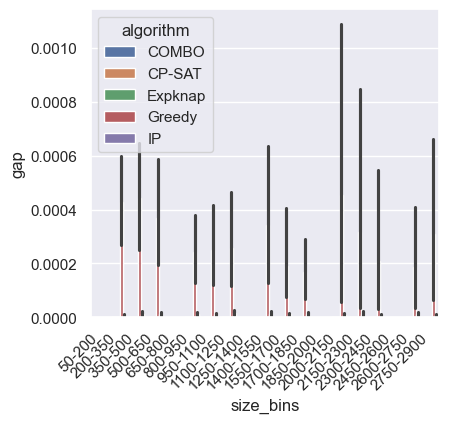

In [7]:
fig, ax = plt.subplots(figsize=(4.5, 4))
sns.barplot(data=results[(results["feasible"] == True)], x='size_bins', y='gap', hue='algorithm', dodge=True, ax=ax)
ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=45, ha='right')
plt.show()

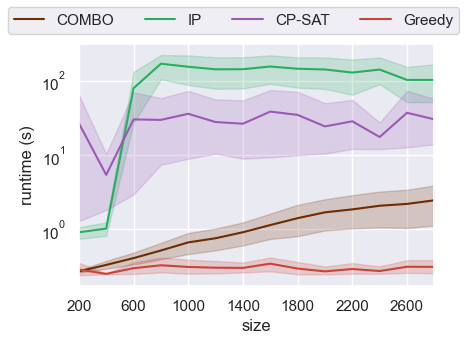

In [15]:
fig, ax = plt.subplots(figsize=(4.5, 3.5))
sns.lineplot(data=results[(results["algorithm"] != "Expknap")],
             x='size',
             y='elapsed_real_time',
             hue='algorithm',
             hue_order=hue_order, ax=ax)
ticks = list(range(200, 2800 + 1, 400))
ax.set_xticks(ticks, ticks)
ax.set_xlim(200, 2800)
ax.set_yscale("log")
ax.set_ylabel("runtime (s)")
ax.legend().remove()
fig.legend(loc='upper left', ncol=4)
fig.tight_layout()
fig.subplots_adjust(top=0.88)
fig.savefig("out/07_runtime_comparison.pdf", bbox_inches='tight')
plt.show()


In [69]:
size_measure = "size_bins"
how_many_optimal = results.groupby(['algorithm', size_measure], observed=True)['optimal'].sum().reset_index()

print(how_many_optimal.columns)
how_many_optimal['optimal'] = how_many_optimal.apply(lambda row: row["optimal"] / len(
    results[(results['algorithm'] == "combo") & (results[size_measure] == row[size_measure])]), axis=1)

fig, ax = plt.subplots(figsize=(12, 4))
sns.barplot(data=how_many_optimal[
    (how_many_optimal["algorithm"] != "expknap") & (how_many_optimal["algorithm"] != "combo") & (
            how_many_optimal["optimal"] < 1)], x=size_measure, y='optimal', hue='algorithm', ax=ax)

# format y axis in percent
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=45, ha='right')
ax.set_ylabel("optimal solutions")
plt.show()

Index(['algorithm', 'size_bins', 'optimal'], dtype='object')


ZeroDivisionError: division by zero

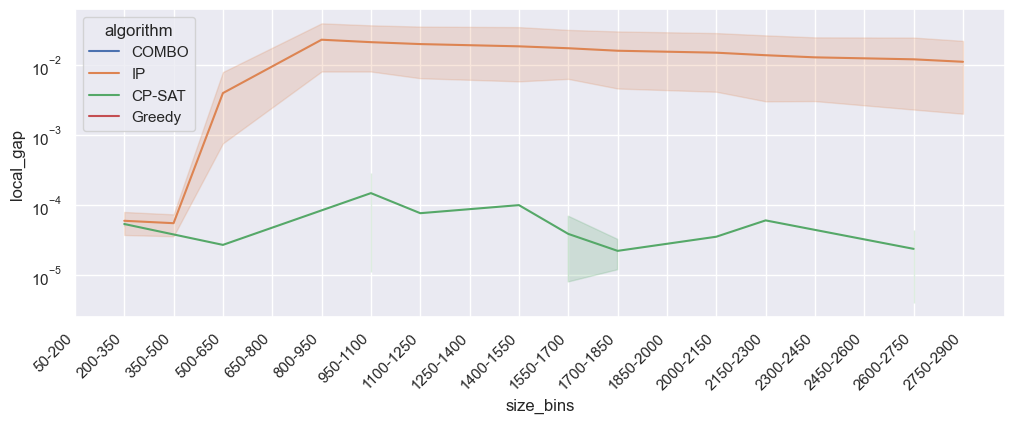

In [59]:
fig, ax = plt.subplots(figsize=(12, 4))
sns.lineplot(data=results[(results["algorithm"] != "Expknap") & (results["local_gap"] > 0)], x='size_bins', y='local_gap', hue='algorithm', hue_order=hue_order, ax=ax)
ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=45, ha='right')
ax.set_yscale("log")
plt.show()

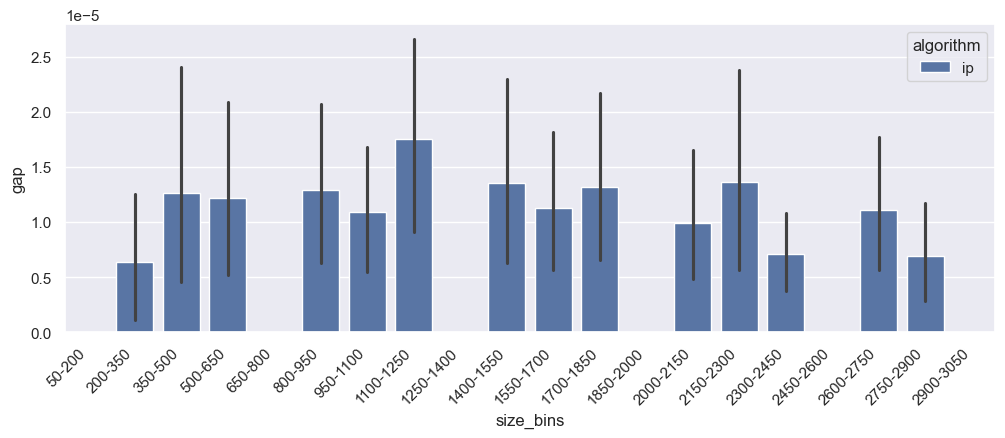

In [37]:
fig, ax = plt.subplots(figsize=(12, 4))
sns.barplot(data=results[(results["algorithm"] == "ip")], x='size_bins', y='gap', hue='algorithm', dodge=True, ax=ax)
ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=45, ha='right')
plt.show()